# Extreme Value Distribution for Groundwater Levels

### Objective

Fit Generalized Extreme Value (GEV) distribution to annual maximum values.

### 0. Load libraries, data and run previously developed code

Install dependences if needed

In [42]:
%pip install --upgrade pandas numpy scipy statsmodels matplotlib datetime
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import necessary libraries (include more if needed).

In [43]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import datetime
import wget

### 1. Read and process the data

**Read the dataset**

In [44]:
data = pd.read_csv("B40C3303001_meetreeks.csv", sep = ';')
# data_name = wget.download('https://surfdrive.surf.nl/files/index.php/s/2Z1OHYg5Gv9PIAK/download')
# data = pd.read_csv(data_name, sep = ';')
data.head()

,date,GW level [cm+MSL]
0,2000 08 03,789
1,2000 08 04,790
2,2000 08 05,791
3,2000 08 06,789
4,2000 08 07,789


**Process and plot the timeseries**

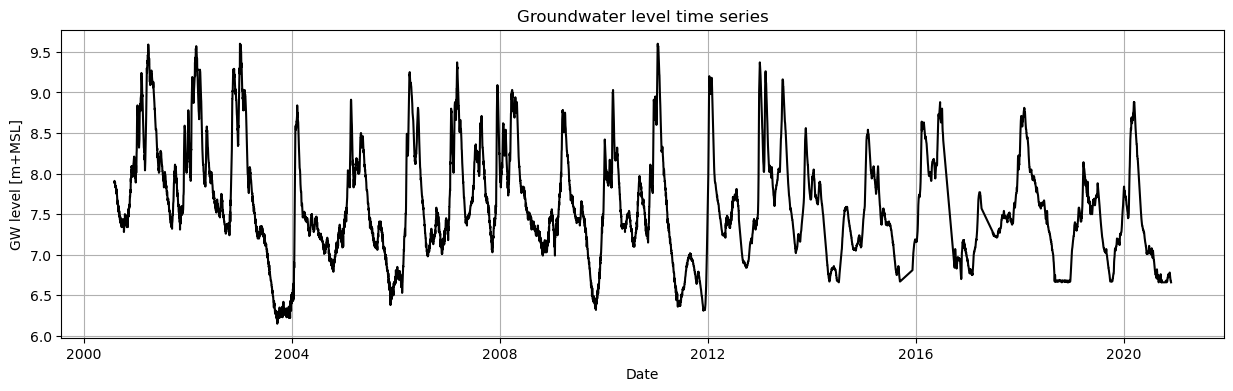

In [45]:
data['date'] = pd.to_datetime(data['date'])

data['GW level [m+MSL]'] = data['GW level [cm+MSL]'] / 100

data.set_axis([np.linspace(0, len(data)-1, len(data), dtype=int)], axis='index', inplace=True)
fig, axs=plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='${Time series}$')
axs.set_title('Groundwater level time series')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()

**Extract annual maxima**

In [46]:
def yearly_maxima(data):
    idx_max = data.groupby(pd.DatetimeIndex(data['date']).year)['GW level [m+MSL]'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

yearly_maxima_list = yearly_maxima(data)
yearly_maxima_list

,date,GW level [cm+MSL],GW level [m+MSL]
140,2000-12-21,821,8.21
239,2001-03-30,959,9.59
576,2002-03-02,957,9.57
883,2003-01-03,960,9.60
1285,2004-02-09,884,8.84
1663,2005-02-21,891,8.91
2075,2006-04-09,925,9.25
2408,2007-03-08,937,9.37
2794,2008-03-28,903,9.03
3149,2009-03-18,878,8.78


**Plot time series including annual maxima**

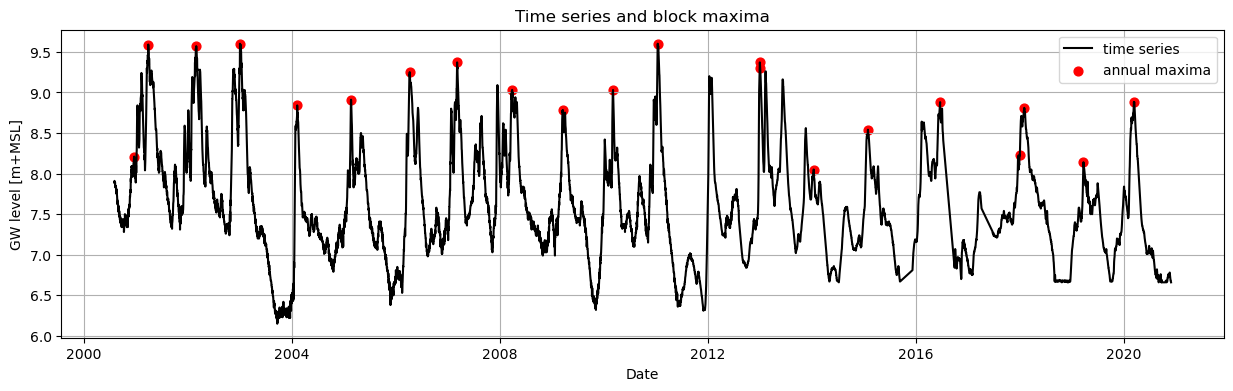

In [65]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['GW level [m+MSL]'], 40, 'r', label = 'annual maxima')
axs.set_title('Time series and block maxima')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

### 2. Calculate the empirical distribution function

Before fitting a parametric distribution, calculate the empirical distribution function from the identified extreme observations.

**Task #1: Calculate the empirical cumulative distribution function**

*Steps*:
- Sort the observations of the variable
- Calculate the length (size) of your observations, *n*
- Assign non-exceedance probabilities to each observation, *p=i/(n+1)*, where *i* is the rank
- Store the probabilities and sorted observations in a DataFrame using: 

`ecdf = pd.DataFrame({'F_x':p_data, 'Hs(m)':sorted_data})`

where p_data are the probabilities and sorted_data your sorted observations.

In [49]:
def calculate_ecdf(data):
    sorted_data = np.sort(data) 
    n_data = sorted_data.size 
    p_data = np.arange(1, n_data+1) / (n_data +1)
    ecdf = pd.DataFrame({'F_x':p_data, 'GW level [m+MSL]':sorted_data})
    return ecdf

Apply the ECDF function to the extremes sampled using annual maxima.

In [50]:
ecdf = calculate_ecdf(yearly_maxima_list['GW level [m+MSL]'])
ecdf.head()

,F_x,GW level [m+MSL]
0,0.045455,8.05
1,0.090909,8.14
2,0.136364,8.21
3,0.181818,8.23
4,0.227273,8.54


Let's see how it looks!

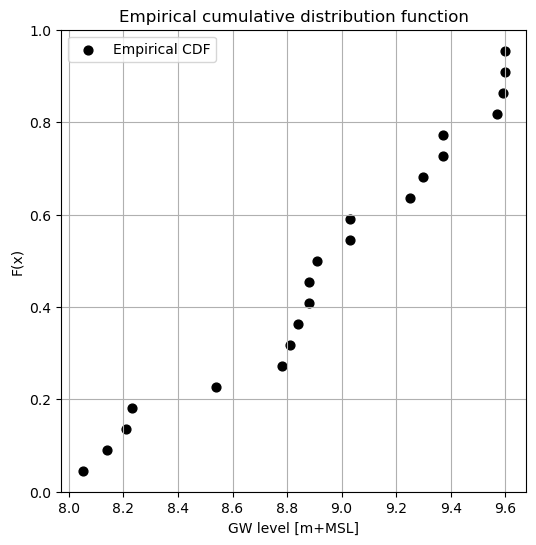

In [51]:
fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['GW level [m+MSL]'], ecdf['F_x'], 40, 'k', label = 'Empirical CDF')
axs.set_title('Empirical cumulative distribution function')
axs.set_ylabel('F(x)')
axs.set_xlabel('GW level [m+MSL]')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

### 3. Fitting the Generalized Extreme Value parametric distribution

**Fit a GEV distribution to the extreme observations obtained with annual maxima**

In [56]:
def fit_GEV(data): 
    GEV_par = stats.genextreme.fit(data, method = 'mle')
    return GEV_par

In [57]:
GEV_par = fit_GEV(yearly_maxima_list['GW level [m+MSL]'])
# Print the estimated parameters
print(f"Shape parameter: {GEV_par[0]}")
print(f"Location parameter: {GEV_par[1]}")
print(f"Scale parameter: {GEV_par[2]}")

Shape parameter: 1.094116916978904
Location parameter: 8.992216962518725
Scale parameter: 0.6649857031610857


**Plot the fit**

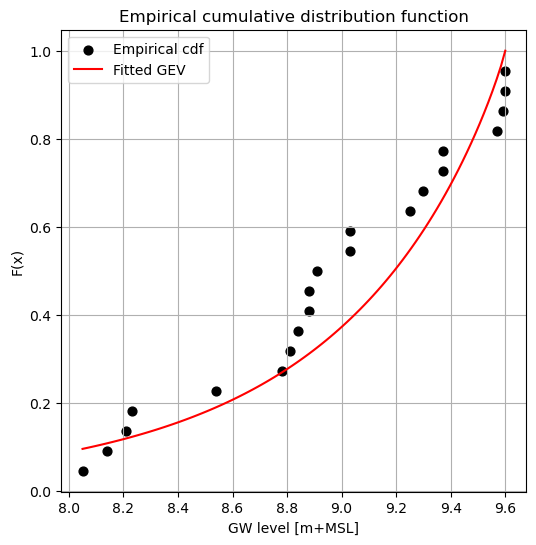

In [58]:
GEV_H = np.linspace(min(yearly_maxima_list['GW level [m+MSL]']), max(yearly_maxima_list['GW level [m+MSL]']),100)
GEV_p = stats.genextreme.cdf(GEV_H, GEV_par[0], GEV_par[1], GEV_par[2])

fig, axs = plt.subplots(1, 1)
axs.scatter(ecdf['GW level [m+MSL]'], ecdf['F_x'], 40, 'k', label = 'Empirical cdf')
axs.plot(GEV_H, GEV_p, 'r', label = 'Fitted GEV')
axs.set_title('Empirical cumulative distribution function')
axs.set_ylabel('F(x)')
axs.set_xlabel('GW level [m+MSL]')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

### 4. Goodness-of-fit

#### Kolmogorov-Smirnov hypothesis test

**Calculate the p-value obtained from the Kolmogorov-Smirnov test to assess the goodness of fit**

In [61]:
stats.kstest(ecdf['GW level [m+MSL]'], stats.genextreme.ppf(ecdf['F_x'], GEV_par[0], GEV_par[1], GEV_par[2]))

KstestResult(statistic=0.23809523809523808, pvalue=0.6028129403170835)

#### QQ-plot

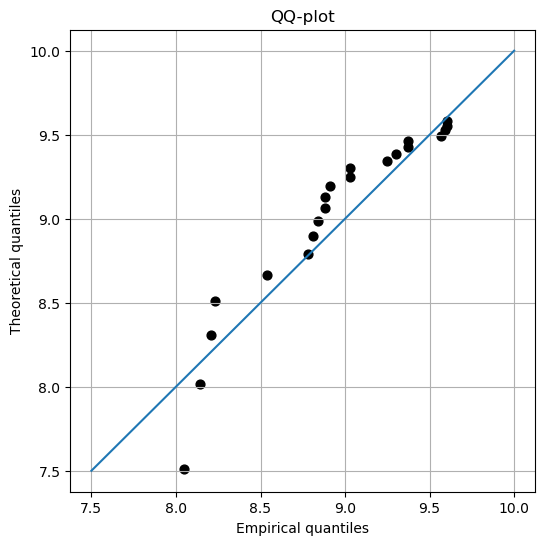

In [63]:
empirical_quantiles = ecdf['GW level [m+MSL]']
pred_quantiles = stats.genextreme.ppf(ecdf['F_x'], GEV_par[0], GEV_par[1], GEV_par[2])

fig, axs = plt.subplots(1, 1)
axs.scatter(empirical_quantiles, pred_quantiles, 40, 'k')
axs.plot([7.5, 10], [7.5,10])
axs.set_title('QQ-plot')
axs.set_ylabel('Theoretical quantiles')
axs.set_xlabel('Empirical quantiles')
fig.set_size_inches(6, 6)
axs.grid()

#### Gumbel probability plot

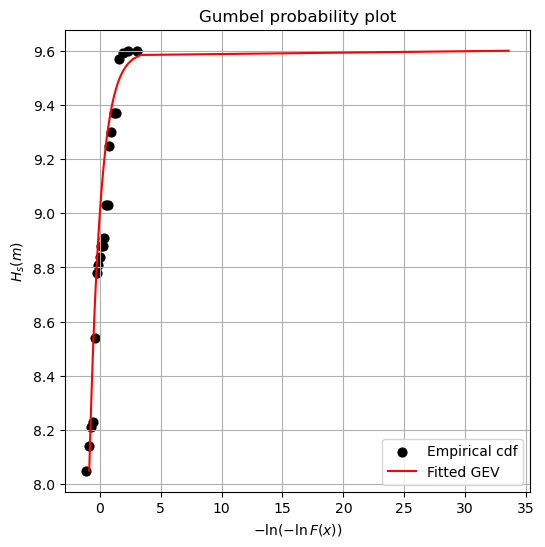

In [64]:
obs_prob_plot_x = -np.log(-np.log(ecdf['F_x']))
obs_prob_plot_y = ecdf['GW level [m+MSL]']

theor_prob_plot_x = -np.log(-np.log(GEV_p))
theor_prob_plot_y = GEV_H

fig, axs = plt.subplots(1, 1)
axs.scatter(obs_prob_plot_x, obs_prob_plot_y, 40, 'k', label = 'Empirical cdf')
axs.plot(theor_prob_plot_x, theor_prob_plot_y, 'r', label = 'Fitted GEV')
axs.set_title('Gumbel probability plot')
axs.set_xlabel('$-\ln(-\ln F(x))$')
axs.set_ylabel('${H_s (m)}$')
fig.set_size_inches(6, 6)
axs.grid()
axs.legend()

### 5. Statistics

**Quasi-permanent**
Fraction of time exceeded = 50%

In [78]:
GW_perma = data['GW level [m+MSL]'].quantile(.5)
GW_perma

7.49

**Frequent** 
Fraction of time exceeded = 1%

In [82]:
GW_freq = data['GW level [m+MSL]'].quantile(.9)
GW_freq

8.62

**Combination**
Return period 10 years (i.e. 10% probability of exceedance per year)

In [86]:
GW_comb_T10=stats.genextreme.ppf(1-1/10, GEV_par[0], GEV_par[1], GEV_par[2])
GW_comb_T10

9.54818638203435

**Characteristic**
Return period 50 years (i.e. 2% probability of exceedance per year)

In [88]:
GW_char_T50=stats.genextreme.ppf(1-1/50, GEV_par[0], GEV_par[1], GEV_par[2])
GW_char_T50

9.59149511352803

**Accidental**
Return period 1000 years (i.e. 0.1% probability of exceedance per year)

In [92]:
GW_acc_T1000=stats.genextreme.ppf(1-1/1000, GEV_par[0], GEV_par[1], GEV_par[2])
GW_acc_T1000

9.599682579107926

#### Plot all statistics

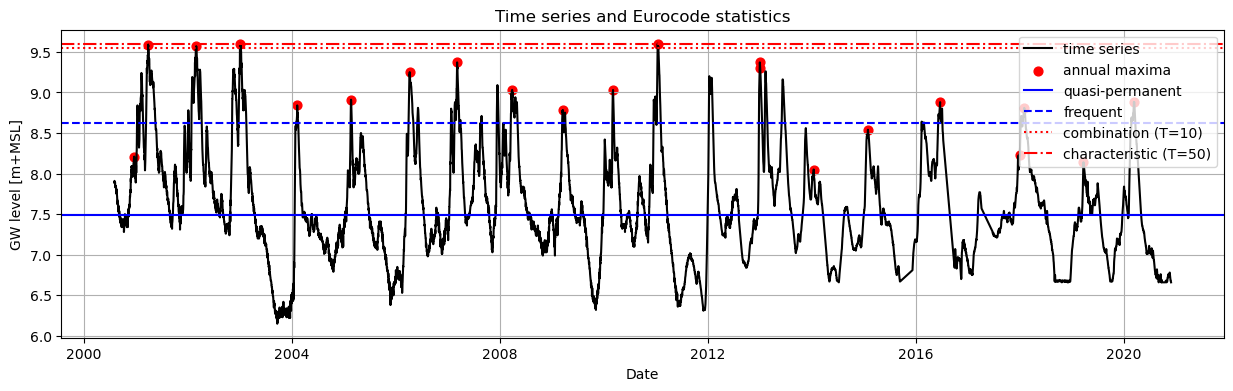

In [95]:
fig, axs = plt.subplots(1, 1)
axs.plot(data['date'], data['GW level [m+MSL]'], 'k', label='time series')
axs.scatter(yearly_maxima_list['date'], yearly_maxima_list['GW level [m+MSL]'], 40, 'r', label = 'annual maxima')
axs.axhline(y = GW_perma, color = 'b', linestyle = '-', label = 'quasi-permanent')
axs.axhline(y = GW_freq, color = 'b', linestyle = '--', label = 'frequent')
axs.axhline(y = GW_comb_T10, color = 'r', linestyle = ':', label = 'combination (T=10)')
axs.axhline(y = GW_char_T50, color = 'r', linestyle = '-.', label = 'characteristic (T=50)')
# axs.axhline(y = GW_acc_T1000, color = 'r', linestyle = '-', label = 'accidental (T=1000)')
axs.set_title('Time series and Eurocode statistics')
axs.set_xlabel('Date')
axs.set_ylabel('GW level [m+MSL]')
fig.set_size_inches(15, 4)
axs.grid()
axs.legend()

#### Plot GEV PDF

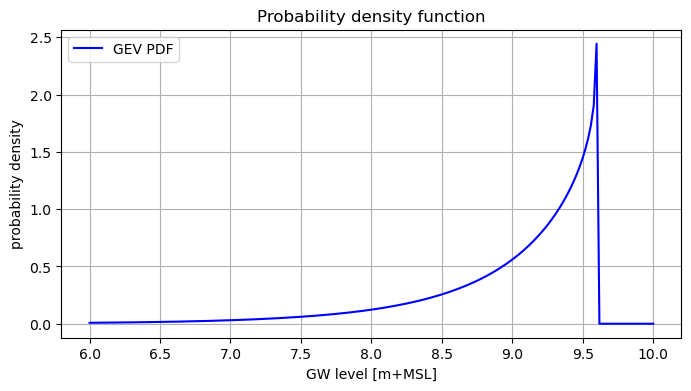

In [99]:
x = np.linspace(6, 10, 200)
fig, axs = plt.subplots(1, 1)
axs.plot(x, stats.genextreme.pdf(x, GEV_par[0], GEV_par[1], GEV_par[2]), 'b', label='GEV PDF')
axs.set_title('Probability density function')
axs.set_xlabel('GW level [m+MSL]')
axs.set_ylabel('probability density')
fig.set_size_inches(8, 4)
axs.grid()
axs.legend()